In [ ]:
# Only for windows and if there are multiple numpy identified
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_SERVICE_FORCE_INTEL"] = "1"

import numpy as np
if not hasattr(np, "string_"): np.string_ = np.bytes_
if not hasattr(np, "unicode_"): np.unicode_ = np.str_

In [ ]:
import sys
sys.path.append("../src")

import torch, numpy as np, matplotlib.pyplot as plt
from config import Cfg
from pl_data import MSDataModule
from pl_module import LitSeg
from pl_utils import render_val_panel
from typing import Tuple
import os

def load_db(cfg_path: str = "../config.yaml") -> Tuple[Cfg, MSDataModule]:
    cfg = Cfg.load(cfg_path)
    dm = MSDataModule(cfg)
    return cfg, dm

def load_model_from_ckpt(cfg_path: str, ckpt_path: str) -> LitSeg:
    cfg = Cfg.load(cfg_path)
    model = LitSeg.load_from_checkpoint(ckpt_path, cfg=cfg, map_location="cpu")
    model.eval()
    return model

In [31]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from typing import List
from pl_utils import render_val_panel

def reorder_x_to_model_channels(x: torch.Tensor, ds_channels: List[str], model_channels: List[str]) -> torch.Tensor:
    """
    x: (C,H,W) del dataset actual
    ds_channels: canales en x
    model_channels: canales que espera el modelo (en el orden guardado en ckpt)
    """
    miss = [c for c in model_channels if c not in ds_channels]
    if miss:
        raise ValueError(f"Faltan canales requeridos por el modelo: {miss}\n"
                         f"ds_channels={ds_channels}\nmodel_channels={model_channels}")
    idx = [ds_channels.index(c) for c in model_channels]
    return x[idx]

@torch.no_grad()
def infer_on_subset_index(subset_ds, model: LitSeg, j: int, thr: float = None, show=True):
    """
    subset_ds: el dataset que cuelga de un DataLoader (p.ej. dm.val_dataloader().dataset)
               Puede ser un torch.utils.data.Subset envolviendo a ChannelSelector.
    j: índice dentro del subset
    """
    # desempaqueta si es Subset
    base = subset_ds.dataset if hasattr(subset_ds, "dataset") else subset_ds

    # toma el sample ya preparado por ChannelSelector (x,y,m,alert_id,rgb)
    s = base[j]
    x, y, m = s["x"], s["y"], s["m"]
    rgb, aid = s["rgb"], s["alert_id"]
    ds_channels = model.hparams.get("channels", None)  # si guardaste channels en hparams
    # Ojo: aquí ds_channels es lo que esperaba el modelo, no lo que trae el sample.
    # Si tu ChannelSelector devuelve también la lista "wanted" en el sample, úsala:
    sample_channels = getattr(base, "wanted", None) or getattr(subset_ds, "wanted", None)
    if sample_channels is None:
        # si no la expone, asume que coincide con model.hparams.channels
        sample_channels = model.hparams.channels

    # reordena x si hace falta
    x = reorder_x_to_model_channels(x, sample_channels, model.hparams.channels)

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    prob = torch.sigmoid(model(x.unsqueeze(0).to(device))).cpu().numpy()[0, 0]
    thr = model.thr if thr is None else thr
    pred = (prob >= thr).astype(np.uint8)

    # Get date
    # print(s.keys())
    # date = s["date"]

    if show:
        gt = y[0].numpy()  # (H,W)
        fig = render_val_panel(rgb, gt, pred, title=f"Infer — {aid}")
        plt.show()

    return prob, pred, s

def find_indices_by_alert(subset_ds, alert_id: str, max_items: int = None) -> List[int]:
    base = subset_ds.dataset if hasattr(subset_ds, "dataset") else subset_ds
    hits = []
    for j in range(len(base)):
        s = base[j]
        if s["alert_id"] == alert_id:
            hits.append(j)
            if max_items and len(hits) >= max_items:
                break
    return hits

def indices_by_alert_sorted(dm: MSDataModule, split: str, alert_id: str, sensor_preference="S2", max_items=None):
    """
    split: "val" o "train"
    sensor_preference: "S2" | "S1" | "any"
    Devuelve índices dentro del subset correspondiente, ordenados por la fecha del sensor elegido.
    """
    dl = dm.val_dataloader() if split=="val" else dm.train_dataloader()
    subset = dl.dataset
    base = subset.dataset if hasattr(subset, "dataset") else subset  # ChannelSelector
    # ChannelSelector suele tener .base -> MultiSensorAlertDataset y .idxs mapeando índices
    ms_base = getattr(base, "base", None)
    idmap = getattr(base, "idxs", None)

    if ms_base is None or idmap is None:
        # fallback: lineal
        return find_indices_by_alert(subset, alert_id, max_items)

    # recopila (subset_idx, date)
    pairs = []
    for sub_idx, ms_idx in enumerate(idmap):
        r = ms_base.records[ms_idx]
        if r["alert_id"] != alert_id:
            continue
        # elige fecha
        dt = None
        if sensor_preference == "S2" and r.get("s2") is not None:
            dt = r["s2"].date
        elif sensor_preference == "S1" and r.get("s1") is not None:
            dt = r["s1"].date
        else:
            dt = (r["s2"].date if r.get("s2") else (r["s1"].date if r.get("s1") else None))
        if dt is not None:
            pairs.append((sub_idx, dt))
    pairs.sort(key=lambda t: t[1])
    out = [p[0] for p in pairs]
    return out[:max_items] if max_items else out

In [4]:
cfg, dm   = load_db("../config.yaml")
model     = load_model_from_ckpt("../config.yaml", "../src/runs/s2idxs1idx_wce_v2/best.ckpt")

c:\Users\Usuario\Desktop\projects\capacity\assignment\notebooks\../src\raster.py:12: UserWarning: no explicit representation of timezones available for np.datetime64
  return np.datetime64(dt)


In [18]:
val_subset = dm.val_dataloader().dataset

alert = "1388023"
idxs = indices_by_alert_sorted(dm, split="val", alert_id=alert, sensor_preference="S2", max_items=4)
print("idxs:", idxs)

idxs: [30, 31]


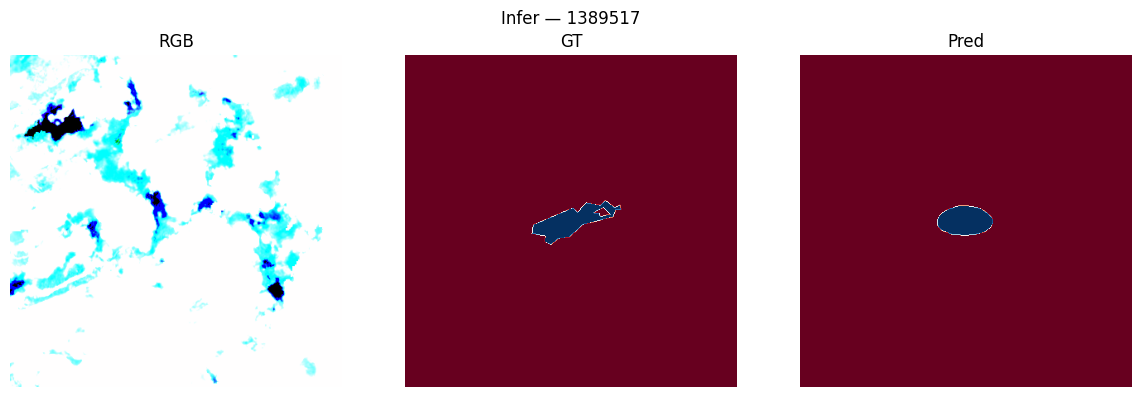

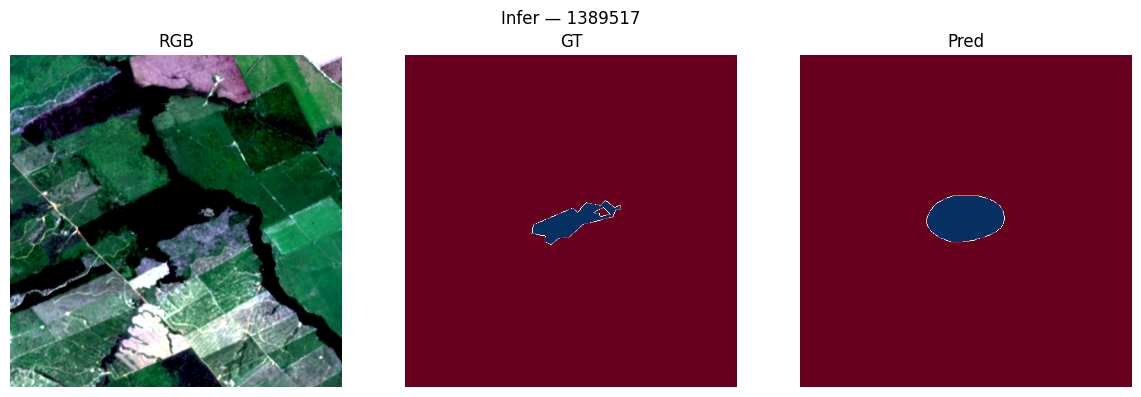

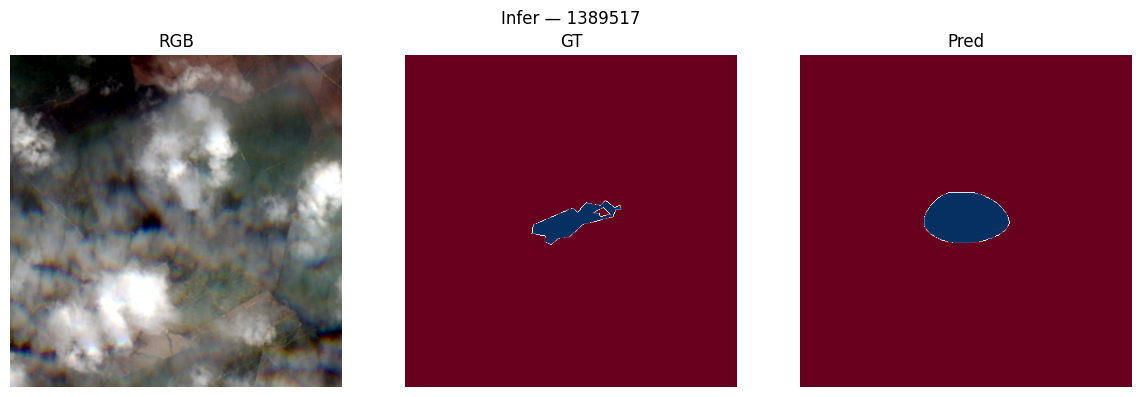

In [7]:
for j in idxs:
    prob, pred, s = infer_on_subset_index(val_subset, model, j, thr=None, show=True)

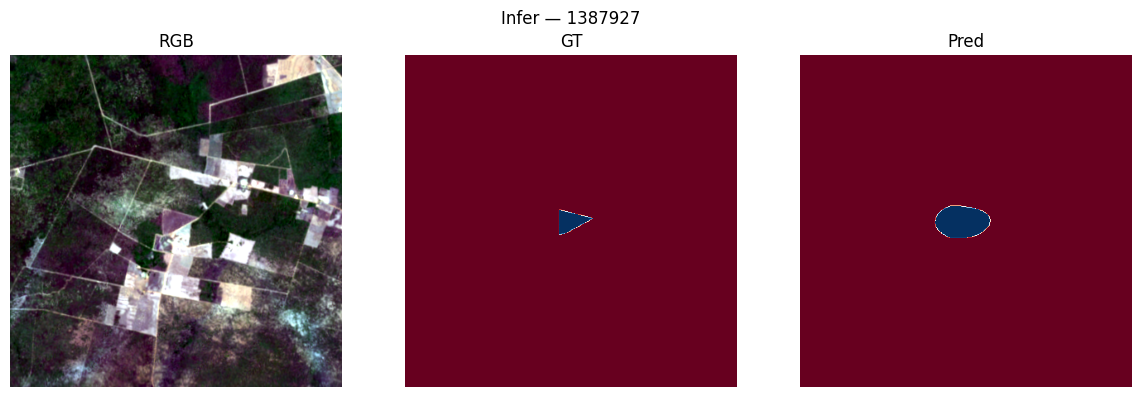

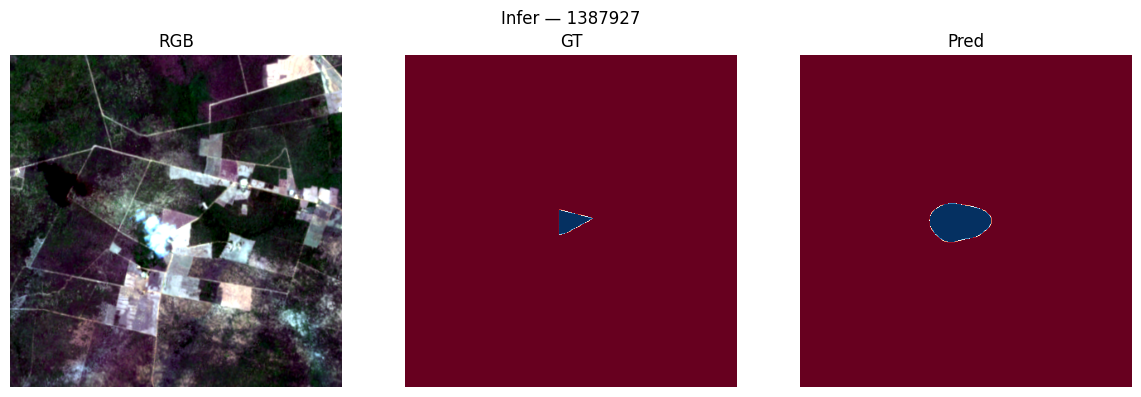

In [9]:
for j in idxs:
    prob, pred, s = infer_on_subset_index(val_subset, model, j, thr=None, show=True)

## For report

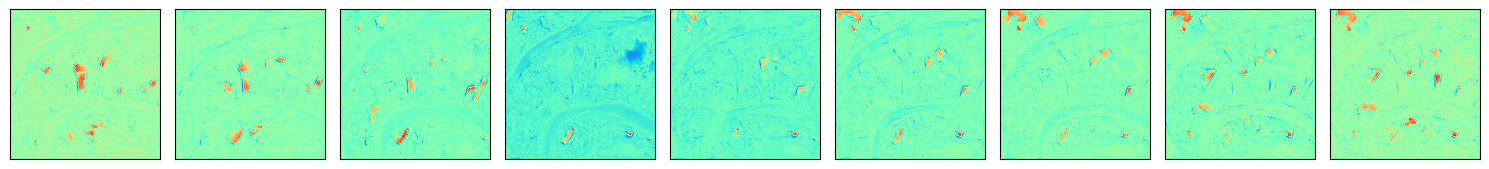

In [ ]:
from pathlib import Path
path_folder = r"C:\Users\Usuario\Desktop\projects\serfor\ai_prediction\app\outputs\2025-08-08_22-16-57"

folder = Path(path_folder)
folder_s2 = folder / "s2"
tif_defor = list(folder.glob("*.tif"))
tif_s2 = list(folder_s2.glob("*.tif"))

import rasterio as rio
fig, ax = plt.subplots(1, len(tif_defor), figsize=(15, 5))
for i in range(len(tif_defor)):
    with rio.open(tif_defor[i], "r") as f:
        data_defor = f.read(1)
    ax[i].imshow(data_defor, cmap="rainbow")
for a in ax:
    a.set_xticks([])
    a.set_yticks([])
plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..3.188].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0045..1.575].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.01375..1.455].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.011..2.208].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.022..1.113].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.01625..1.091].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.03..1.033].
Clipping input data to the valid range for ims

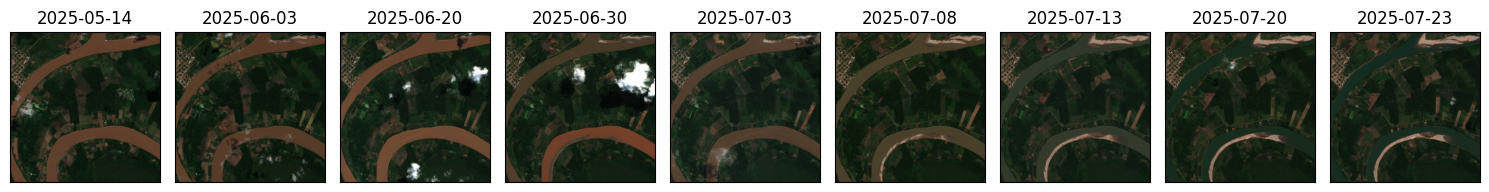

In [75]:
import rasterio as rio
fig, ax = plt.subplots(1, len(tif_s2), figsize=(15, 5))
for i in range(len(tif_s2)):
    with rio.open(tif_s2[i], "r") as f:
        data_s2 = f.read([1,2,3])
        data_s2 = np.moveaxis(data_s2, 0, -1)*2.5/10000
        ax[i].imshow(data_s2)
        ax[i].set_title(tif_s2[i].stem)
for a in ax:
    a.set_xticks([])
    a.set_yticks([])
plt.tight_layout()
plt.show()